# Feature Sets
In this exercise, we'll create a good, minimal set of features.

So far, we've thrown all of our features into the model. In this exercise, we'll reduce the number of features, yielding a leaner model that performs just as well. Models with fewer features are easier to maintain and take fewer resources than those with more features.

As before, let's load up and prepare our data.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [7]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [8]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


In [15]:
def preprocess_features(housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["MSZoning",
     "YearRemodAdd",
     "Utilities",
     "Neighborhood",
     "HouseStyle",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["total_floor_sf"] = (
    housing_dataframe["1stFlrSF"] +
    housing_dataframe["2ndFlrSF"])
  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["SalePrice"] = (
    housing_dataframe["SalePrice"] / 1000.0)
  return output_targets

In [16]:
training_examples = preprocess_features(housing_dataframe.head(1000))
training_examples.describe()

,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,total_floor_sf
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,0.4,1985.1,0.0,9.5,1.1,2.9,5.6,1501.4
std,0.8,20.4,0.0,5.8,1.3,0.8,1.1,508.6
min,0.0,1950.0,0.0,0.0,0.0,0.0,1.0,334.0
25%,0.0,1967.0,0.0,5.0,0.0,2.0,5.0,1117.8
50%,0.0,1994.0,0.0,10.0,1.0,3.0,5.0,1454.5
75%,0.0,2004.0,0.0,13.0,1.0,3.0,6.0,1768.0
max,4.0,2010.0,1.0,24.0,7.0,8.0,9.0,4676.0


In [17]:
training_targets = preprocess_targets(housing_dataframe.head(1000))
training_targets.describe()

,SalePrice
count,1000.0
mean,182.0
std,80.4
min,34.9
25%,130.0
50%,162.9
75%,215.0
max,755.0


In [18]:
validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_examples.describe()

,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,total_floor_sf
count,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,0.3,1983.8,0.0,9.3,1.2,2.9,5.6,1517.8
std,0.8,21.2,0.0,6.0,1.3,0.8,1.1,542.4
min,0.0,1950.0,0.0,0.0,0.0,0.0,3.0,438.0
25%,0.0,1964.8,0.0,5.0,0.0,2.0,5.0,1128.0
50%,0.0,1992.0,0.0,9.0,1.0,3.0,5.0,1472.0
75%,0.0,2004.0,0.0,14.0,1.0,3.0,6.0,1784.8
max,4.0,2010.0,0.0,24.0,7.0,6.0,9.0,5642.0


In [19]:
validation_targets = preprocess_targets(housing_dataframe.tail(500))
validation_targets.describe()

,SalePrice
count,500.0
mean,177.0
std,76.3
min,37.9
25%,129.0
50%,160.0
75%,203.0
max,745.0


## 3: Develop a good feature set.

**What's the best performance you can get with just 2 or 3 features?**

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each feature compared to other features.

Here, correlation is defined as the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).  You don't have to understand the mathematical details for this exercise.

Correlation values have the following meanings:

  * `-1.0`: perfect negative correlation
  * `0.0`: no correlation
  * `1.0`: perfect positive correlation

In [20]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["SalePrice"]

correlation_dataframe.corr()

,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,total_floor_sf,target
MSZoning,1.0,0.0,-0.0,-0.1,-0.0,-0.1,-0.0,-0.1,-0.1
YearRemodAdd,0.0,1.0,-0.0,-0.2,-0.2,0.0,0.1,0.3,0.5
Utilities,-0.0,-0.0,1.0,0.0,0.1,0.0,0.0,-0.0,-0.0
Neighborhood,-0.1,-0.2,0.0,1.0,0.1,-0.0,-0.1,-0.1,-0.1
HouseStyle,-0.0,-0.2,0.1,0.1,1.0,-0.1,0.2,-0.2,-0.2
BedroomAbvGr,-0.1,0.0,0.0,-0.0,-0.1,1.0,0.0,0.5,0.2
OverallCond,-0.0,0.1,0.0,-0.1,0.2,0.0,1.0,-0.1,-0.1
total_floor_sf,-0.1,0.3,-0.0,-0.1,-0.2,0.5,-0.1,1.0,0.7
target,-0.1,0.5,-0.0,-0.1,-0.2,0.2,-0.1,0.7,1.0


Ideally, we'd like to have features that are strongly correlated with the target.

We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

Use this information to try removing features.  You can also try developing additional synthetic features, such as ratios of two raw features.

For convenience, we've included the training code from the previous exercise.

In [23]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  feature_columns = set([tf.contrib.layers.real_valued_column(my_feature) for my_feature in training_examples])
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )
  
  # Create input functions
  training_input_fn = learn_io.pandas_input_fn(
      x=training_examples, y=training_targets["SalePrice"],
      num_epochs=None, batch_size=batch_size)
  predict_training_input_fn = learn_io.pandas_input_fn(
      x=training_examples, y=training_targets["SalePrice"],
      num_epochs=1, shuffle=False)
  predict_validation_input_fn = learn_io.pandas_input_fn(
      x=validation_examples, y=validation_targets["SalePrice"],
      num_epochs=1, shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = list(linear_regressor.predict(input_fn=predict_training_input_fn))
    validation_predictions = list(linear_regressor.predict(input_fn=predict_validation_input_fn))
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

## 4. Trying with some features
We tried these features. As usual, this is just one of many examples that show good results.
  * median_income
  * latitude

We adjusted the learning rate a bit as well.

Training model...
RMSE (on training data):
  period 00 : 158.11
  period 01 : 119.46
  period 02 : 85.75
  period 03 : 68.91
  period 04 : 63.69
  period 05 : 61.94
  period 06 : 61.31
  period 07 : 60.47
  period 08 : 59.44
  period 09 : 59.89
Model training finished.


LinearRegressor(params={'gradient_clip_norm': 5.0, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f585a401c90>, 'joint_weights': False, 'optimizer': <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f585a3d4ed0>, 'feature_columns': set([_RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='total_floor_sf', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)])})

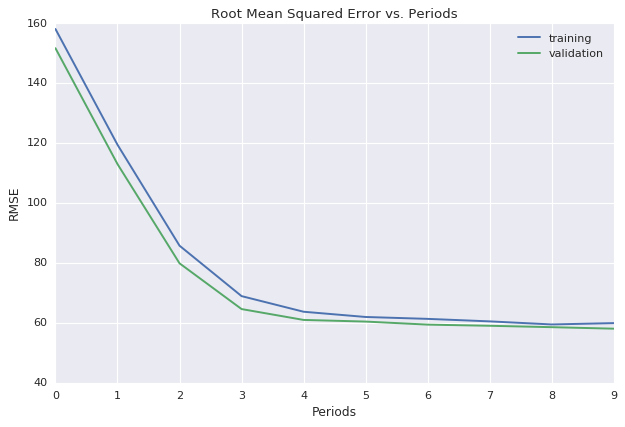

In [25]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = [
    'total_floor_sf',
    'YearRemodAdd'
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.0001,
    steps=350,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

## 5: Showing the relationship between total_floor_sf and SalePrice.

Plotting `total_floor_sf` vs. `SalePrice` shows that there really is a linear relationship there.


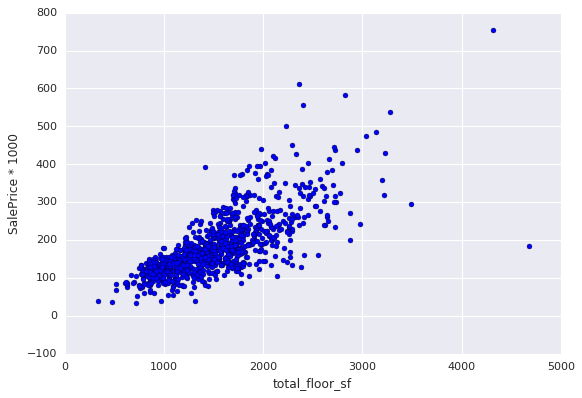

In [28]:
plt.xlabel("total_floor_sf")
plt.ylabel("SalePrice * 1000")
plt.scatter(training_examples["total_floor_sf"], training_targets["SalePrice"])


In [ ]:
#
# Your code here: train on a new data set that includes synthetic features based on latitude.
#